# ML4DS - Model Selection

## Introduction

You will explore the various options for model selection on a *clustering* task.

In the first section, you will use synthetic data, where we know the true number of clusters. In the second (which will make up the assessed task), you will compare multiple methods for model selection on a real dataset.

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn import mixture
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import itertools
from scipy import linalg
import matplotlib as mpl

/Users/spitfire/.pyenv/versions/anaconda3-2020.11/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


# Part 1: synthetic data

### Generate some data

Make data from a mixture of gaussians using sklearn `make_blobs` method. Try experimenting with:
- The number of centers
- the `cluster_std`
- The total number of samples

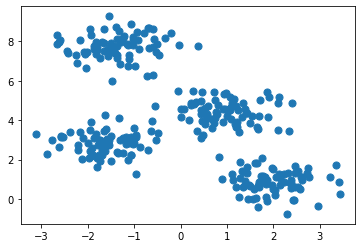

In [2]:
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.6, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

# Clustering - K-Means Example

Using the `KMeans` model, try and optimise, plot a graph of $K$ versus the `inertia_` value of the clustering. The `inertia_` value is the quantity that is minimised when K-means is training: the total sum of squared errors between the observations and the cluster centre to which they are assigned.

__Question__: what do you notice about this curve? Do you think you could use it to choose the correct number of clusters? See e.g. https://en.wikipedia.org/wiki/Elbow_method_(clustering). What happens when you vary the parameters used to generate the data (above)

__Question__ Choose K using the Elbow Method

__Question__: using the value of $K$ you have chosen, fit the clustering and then use the following code to plot the data coloured by cluster assignment. You can get the cluster assignment using the following code:
`y_kmeans = kmeans.predict(X)`

In [238]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
y_kmeans = kmeans.predict(X)

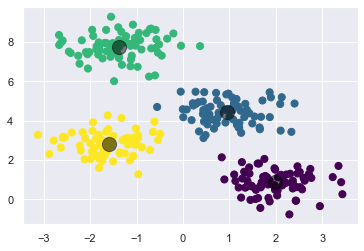

In [239]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Silhouette Score for K for K-Means

The silhouette score (https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) is a method for optimising $K$ in a clustering setting. It computes how similar objects are to other objects within their cluster compared to how similar they are to points in neighbouring clusters.

__Question__: make a plot of Silhouette scores for the example data above. Vary the data generation parameters. Does the optimal $K$ from Silhouette agree with that from inspecting the inertia?

In [5]:


for n_clusters in range(2,6):

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)


For n_clusters = 2 The average silhouette_score is : 0.5426422297358302
For n_clusters = 3 The average silhouette_score is : 0.5890390393551768
For n_clusters = 4 The average silhouette_score is : 0.6819938690643478
For n_clusters = 5 The average silhouette_score is : 0.5923027677672242


## BIC for K-means

Although K-means is not optimised by maximising the likelihood, you can compute a quanitity that is interpretable as BIC. To do this, compute:

$KD\ln(N) - E$

where $E$ is the negative of the `inertia_` property of K-means, and $D$ is the dimension of the data (in our case, 2).

__Question:__ for the data above, plot BIC for K-means as a function of $K$ for $K$ varying from 1 to 30. Does it agree with the previous answers?


In [159]:
# -2 * LL + log(N) * k
d = 2
n = X.shape[0]
for k in range(1,30):
    e = KMeans(n_clusters=k, random_state=0).fit(X).inertia_
    print(k*d*np.log(n)+e,e)

2823.5451602525472 2812.137595303235
1213.5974892629697 1190.782359364345
581.1138453105673 546.8911504626301
257.63625600808433 212.00599621083472
245.81106031429914 188.77323556773712
239.1746927272242 170.7293030313498
232.4380648181741 152.5851101729873
229.65771346780772 138.3971938733085
227.12324404703998 124.45515950322836
227.2083215994699 113.13267210634591
226.62182597164525 101.13861152920884
226.8241774720879 89.93339808033907
232.67532272943728 84.37697838837605
237.55921485038007 77.85330556000645
244.10763737641315 72.99416313672715
252.04236311345664 69.52132392445822
257.8272886639052 63.89868452559437
266.0028731756318 60.66670408800859
272.38018287060083 55.63644883366523
281.6536129518512 53.502313965603136
289.8186237004216 50.25975976486116
299.56568225435996 48.5992533694871
308.14182635969576 45.767832525510535
317.4185421168105 43.63698333331288
326.3460202889551 41.15689655614505
336.2416299617775 39.64494127965502
346.410892387629 38.406638756194184
356.3013

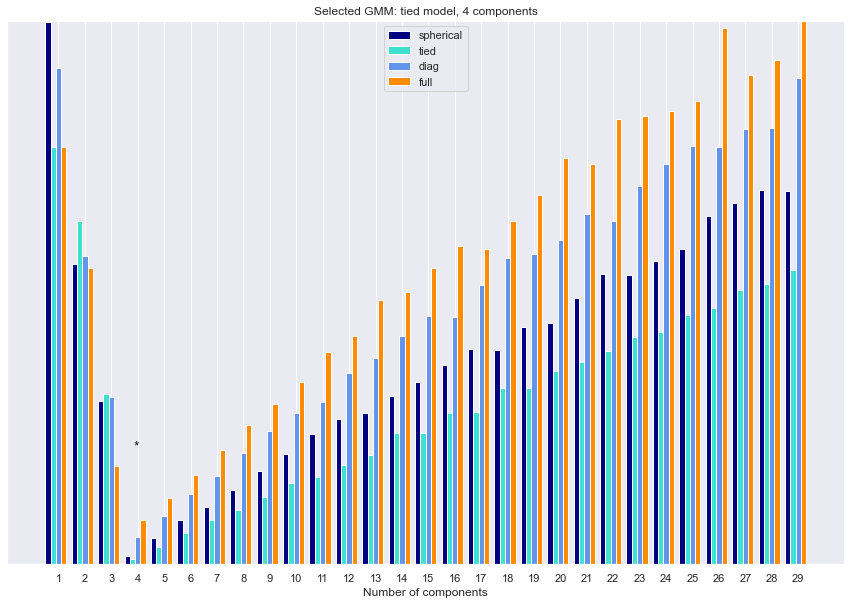

In [160]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 30)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 10))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.8 + .2 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

# Plot the winner

# make_ellipses(gmm,plt.gca())
    
plt.xticks((n_components_range))
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.show()

# Mixture Models

Statistical mixture models are somewhat related to K-means but place the clustering problem within a statistical framework.

We will use Gaussian mixtures: models in which data from each cluster is assumed to come from a different Gaussian. With mixture models we have two model selection challenges: choosing $K$ and choosing the form of the Gaussian covariance matrices:

- spherical: the covariance matrices are of the form $\sigma^2\mathbf{I}$ (where $\mathbf{I}$ is an identity), i.e. the variance is the same in all dimensions and there is no correlation structure
- diagonal: there is no correlation structure, but the variance can be different in each dimension
- tied: all Gaussians share the same covariance matrix
- full: each Gaussian can have a different covariance matrix that can have full correlation structure

See https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html

To create a Gaussian mixture object using sklearn with (say) a tied covariance structure, use:

```{python}
from sklearn import mixture
gmm = mixture.Gaussian(n_components = K,covariance_type='cv_type')
```

__Note__
- the `mixture.Gaussian` object has methods to compute BIC and AIC (`gmm.bic(X)` etc)
- you can also perform cross validation with a mixture, but computing the likelihood on held-out observations. The likelihood is the standard mixture likelihood:

$L = \prod_n \sum_k \pi_k p(x_n|k)$

where the product is over the held-out data, the sum is over the clusters, $\pi_k$ is the prior weight of cluster k (`gmm.weights_`) and $p(x_n|k)$ is the Gaussian likelihood of the nth observation in the kth cluster.

## Additional imports...

In [7]:
import numpy as np
import itertools
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from sklearn import mixture

### Load a real data set

In [218]:
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
print(n_samples,n_features)

1797 64


### Useful code to plot a single digit

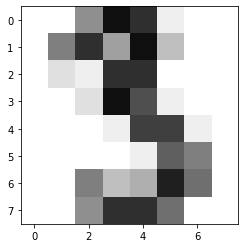

In [9]:
# method to plot a single digit
def plot_digit(digit_data):
    im = plt.imshow(digit_data.reshape(8,8), cmap='binary')
    im.set_clim(0, 16)

#¬†example - plot the third one in the dataset    
plot_digit(digits.data[3])

### Project the data into 2D

In [10]:
reduced_data = PCA(n_components=2).fit_transform(data)

([], [])

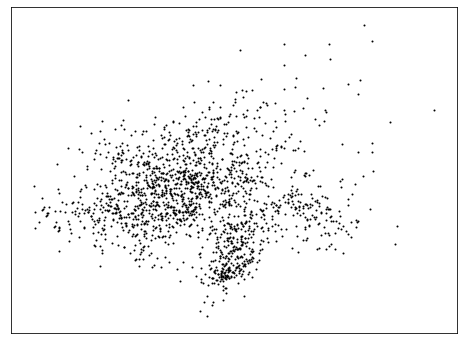

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

## The task

Explore different model selection strategies to determine the number of clusters required for a Gaussian mixture clustering of this data (in the 2D PCA space) **and** the correct choice of covariance matrix structure (from the options listed above).

You should try multiple methods (BIC, AIC, Silhouette, and cross-validation)

Explore the clusterings suggested by each method, and look to see which digits are being grouped or split (if the optimal number is not 10 (digits 0-9).

The following method might be useful to plot the result of the clustering(s) and nice covariance ellipses

In [78]:
from matplotlib.patches import Ellipse
import matplotlib.cm as cm
colors = ['navy', 'turquoise', 'darkorange','red'] # will need to add other colours here if more clusters
def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'tired':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')
    

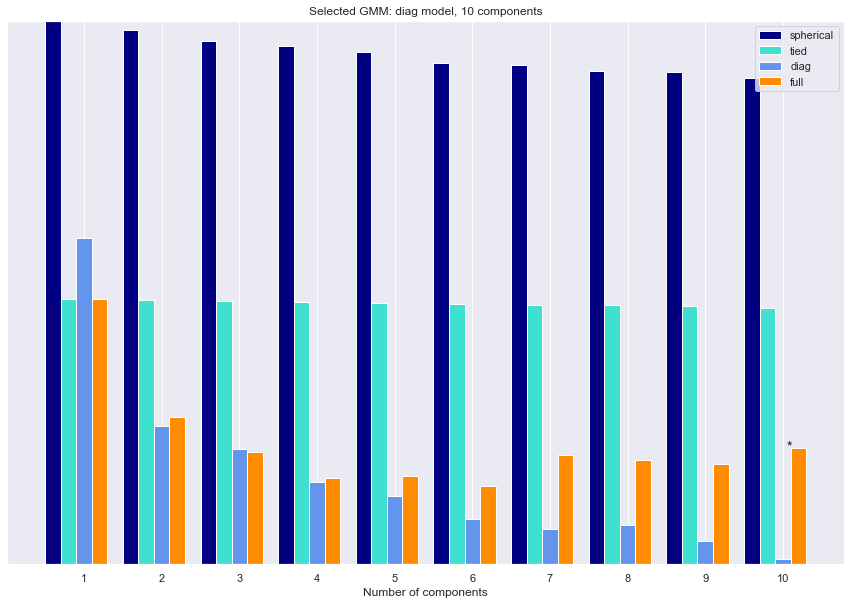

In [246]:
# BIC Clustering function
lowest_bic = np.infty
bic = []
n_components_range = range(1, 11)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(digits.data)
        bic.append(gmm.bic(digits.data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(15, 10))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.8 + .2 * bic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

# Plot the winner

# make_ellipses(gmm,plt.gca())
    
plt.xticks((n_components_range))
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.show()

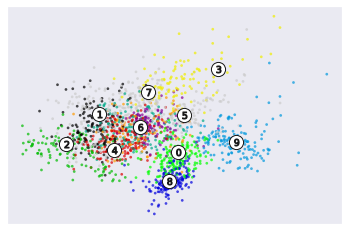

In [247]:
colors = cm.nipy_spectral(cluster_labels.astype(float) / 10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
clusterer = KMeans(n_clusters=best_gmm.n_components, random_state=30).fit(reduced_data)
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')
    
plt.xticks(())
plt.yticks(())
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.11832841100655983
For n_clusters = 3 The average silhouette_score is : 0.12649498093440542
For n_clusters = 4 The average silhouette_score is : 0.12801530390921514
For n_clusters = 5 The average silhouette_score is : 0.13806580710297167
For n_clusters = 6 The average silhouette_score is : 0.15125664808497616
For n_clusters = 7 The average silhouette_score is : 0.15958911346149623
For n_clusters = 8 The average silhouette_score is : 0.17883754228140428
For n_clusters = 9 The average silhouette_score is : 0.18903346139543384
For n_clusters = 10 The average silhouette_score is : 0.18246601958265693
For n_clusters = 11 The average silhouette_score is : 0.1807769078677586
For n_clusters = 12 The average silhouette_score is : 0.18266385399612373
For n_clusters = 13 The average silhouette_score is : 0.1855404169267227
For n_clusters = 14 The average silhouette_score is : 0.18502819807662854


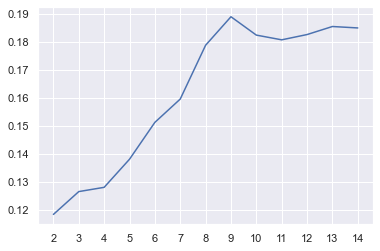

In [209]:
# Silhouette score
sho_avg = []
for n_clusters in range(2,15):

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 30 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=30)
    cluster_labels = clusterer.fit_predict(digits.data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(digits.data, cluster_labels)
    sho_avg.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(digits.data, cluster_labels)
plt.plot(list(range(2,15)),sho_avg)
plt.xticks(np.arange(2,15))
plt.show()

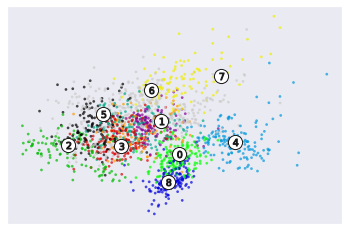

In [221]:
# K

colors = cm.nipy_spectral(cluster_labels.astype(float) / 10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
clusterer = KMeans(n_clusters=np.where(sho_avg==np.max(sho_avg))[0][0]+2, random_state=30).fit(reduced_data)
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')
    
plt.xticks(())
plt.yticks(())
plt.show()
plt.title("Silhouette score cluster with 9")

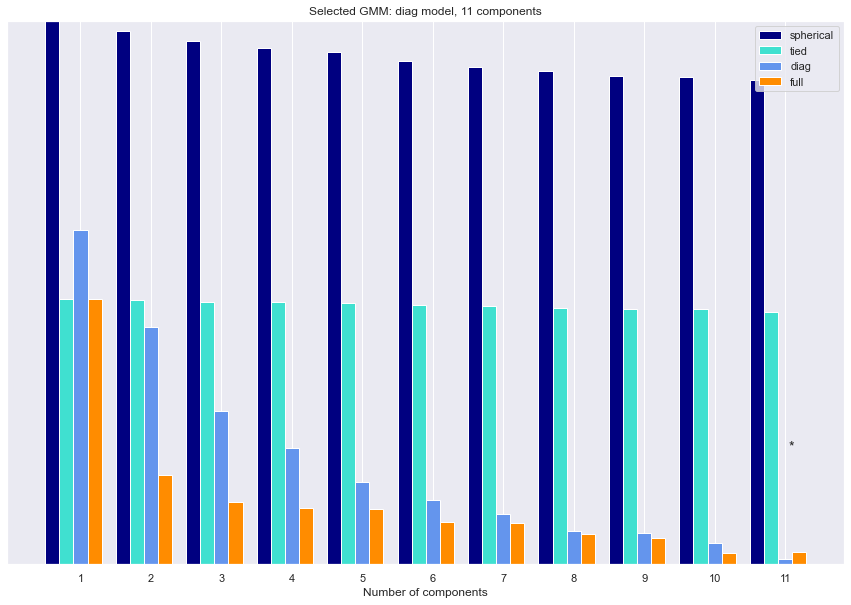

In [234]:
lowest_aic = np.infty
aic = []
n_components_range = range(1, 12)
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(digits.data)
        aic.append(gmm.aic(digits.data))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm

aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the AIC scores
plt.figure(figsize=(15, 10))
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):(i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('BIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.8 + .2 * aic.max(), '*', fontsize=14)
plt.xlabel('Number of components')
plt.legend([b[0] for b in bars], cv_types)

# Plot the winner

# make_ellipses(gmm,plt.gca())
    
plt.xticks((n_components_range))
plt.yticks(())
plt.title(f'Selected GMM: {best_gmm.covariance_type} model, '
          f'{best_gmm.n_components} components')
plt.show()
    

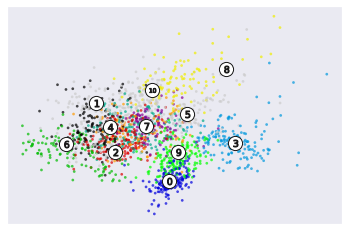

In [235]:
# K

colors = cm.nipy_spectral(cluster_labels.astype(float) / 10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the clusters
clusterer = KMeans(n_clusters=best_gmm.n_components, random_state=30).fit(reduced_data)
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')
    
plt.xticks(())
plt.yticks(())
plt.show()

The number: 1 accuracy = 0.09905118601747817
The number: 2 accuracy = 0.10687265917602998
The number: 3 accuracy = 0.12194132334581771
The number: 4 accuracy = 0.058476903870162286
The number: 5 accuracy = 0.09192883895131086
The number: 6 accuracy = 0.08521847690387016
The number: 7 accuracy = 0.10958177278402
The number: 8 accuracy = 0.10734706616729088
The number: 9 accuracy = 0.1358426966292135
The number: 10 accuracy = 0.144625468164794
The number: 11 accuracy = 0.10066791510611736


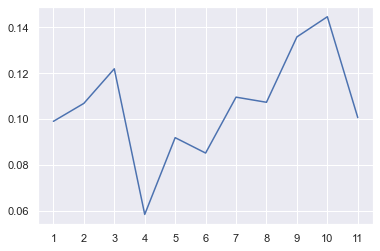

In [201]:

"""
digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target
"""
from sklearn.model_selection import cross_val_score,train_test_split
cvs = []
for i in range(1,12):
    clusterer = KMeans(n_clusters=i, random_state=30)
    cvs.append(cross_val_score(clusterer,digits.data,digits.target,cv=20,scoring='accuracy').mean())
    print(f"The number: {i} accuracy = {cvs[-1]}")
    
cvs = np.array(cvs)
xi = list(range(1,12))
plt.plot(xi,cvs)
plt.xticks(np.arange(1,12))
plt.show()

Text(0.5, 1.0, 'Clustering with carss vaildation value')

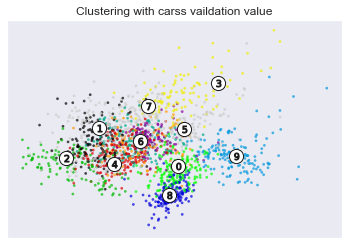

In [222]:
# cross vaildation value scatter

colors = cm.nipy_spectral(cluster_labels.astype(float) / 10)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

    # Labeling the 
clusterer = KMeans(n_clusters=np.where(cvs==np.max(cvs))[0][0]+1, random_state=30).fit(reduced_data)
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
plt.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')
plt.xticks(())
plt.yticks(())
plt.title("Clustering with carss vaildation value")